In [1]:
!pip install torch
!pip install torch-geometric
!pip install geopy

  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2024.10.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1

In [13]:
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

import networkx as nx
from geopy.distance import geodesic

import concurrent.futures

### Preprocess and sampling

In [ ]:
if input("Do you want to preprocess the data? Press Enter to continue.") != "":
    raise Exception("Stop")

In [52]:
# Import complete data
df=pd.read_csv('data.csv')

In [53]:
# Sample random rows from the dataframe
df=df.sample(n=100000)

In [54]:
# Remove rows with missing values
df = df.dropna()

# Reset the index
df = df.reset_index(drop=True)

In [55]:
df['date'].apply(lambda x: re.sub(r'^\d{4}-\d{2}-\d{2}\s', '', x)).str.split('.').str[0]

0        12:18:26
1        02:34:00
2        12:51:02
3        01:43:48
4        02:20:23
           ...   
91559    02:37:46
91560    13:16:56
91561    00:58:55
91562    00:58:56
91563    02:24:21
Name: date, Length: 91564, dtype: object

In [56]:
# Create a new column for the day and hour
df['day'] = df['date'].apply(lambda x: re.sub(r'\s.*$', '', x))
df['day']=pd.to_datetime(df['day'])

df['hour']= df['date'].apply(lambda x: re.sub(r'^\d{4}-\d{2}-\d{2}\s', '', x)).str.split('.').str[0]


In [57]:
df.drop('date', axis=1, inplace=True)

In [39]:
# Create timestamp of the date
# df['date'] = pd.to_datetime(df['date'])

In [58]:
# Move day and hour columns after file column
cols = df.columns.tolist()
cols = cols[:1] + cols[-2:] + cols[1:-2]
df = df[cols]

In [59]:
# Save the sampled data
df.to_csv('data_sampled.csv', index=False)

### Data analysis

In [89]:
# Import the data
df=pd.read_csv('data_sampled.csv', parse_dates=['day'])

In [21]:
df=df[df['day'] == '2015-01-03'].sample(10)

In [59]:
# Display the first few rows of the dataframe
df

,file,day,hour,atrack,xtrack,lat,lon,surf_alt,solar_zenith_angle,solar_azimuth_angle,satellite_position,air_temp_masked,surf_air_temp_masked,surf_temp_masked,surf_spec_hum_masked,h2o_vap_tot_masked,cloud_liquid_water_masked,atmosphere_mass_content_of_cloud_ice_masked
14773,10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150103...,2015-01-03,00:48:26,6,32,49.000378,24.728512,274.572780,141.60495,60.129253,[4365181. 1700108.4 5467210. ],[196.91139 194.71213 202.94809 212.86552 221.8...,269.58795,269.64938,0.002394,6.152318,0.003691,0.000536
50134,10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150103...,2015-01-03,02:33:45,80,94,37.617218,-22.282835,0.000000,160.37083,45.517384,[5739931. -897713.8 4255830.5],[202.3558 195.1366 197.60541 212.47357 229.4...,289.86380,289.85257,0.007297,12.790777,0.003848,0.000000
76714,10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150103...,2015-01-03,02:30:28,7,6,45.219320,6.758324,2273.132300,138.44264,72.210464,[4845698.5 -415612.94 5309037. ],[197.29051 191.90204 200.33473 210.29326 217.9...,274.45312,263.40580,0.004706,5.020969,0.000279,0.000000
59335,10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150103...,2015-01-03,02:27:32,76,14,55.694748,10.252147,0.314256,132.94194,65.012794,[3857352. 10875.812 6077868. ],[198.12288 196.85309 207.03545 221.52481 235.1...,277.30930,277.33932,0.003878,7.977442,0.007089,0.002311
72091,10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150103...,2015-01-03,02:34:02,87,39,35.071712,-7.736685,0.000000,151.44070,72.719870,[5813372. -943619.5 4145076. ],[202.29918 198.26189 199.09972 203.98935 222.7...,289.27270,290.88986,0.007407,7.341459,0.000212,0.000102
55474,10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150103...,2015-01-03,00:50:50,60,2,38.522064,30.830198,1290.120600,140.70845,79.120180,[5160411. 1682894. 4732002.],[205.4019 201.92215 202.44365 206.49773 213.7...,268.05334,268.05893,0.003468,4.109504,0.000278,0.000150
8161,10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150103...,2015-01-03,02:24:46,13,74,68.412000,-2.911039,0.000000,130.39856,40.151690,[2785718. 392574.94 6625025. ],[201.44884 204.32715 219.73624 233.04897 243.5...,267.92545,276.76312,0.002220,3.232900,0.012766,0.003054
20540,10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150103...,2015-01-03,12:18:06,133,85,56.278940,18.389704,0.000000,81.22515,200.255310,[4123085.2 437987.3 5885368. ],[196.65172 193.80042 206.92009 225.79518 244.7...,277.71976,278.52856,0.005701,7.231474,0.004150,0.000281
87625,10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150103...,2015-01-03,00:51:44,80,91,39.301760,5.266628,0.000000,158.04724,46.561040,[5426874. 1663022.2 4432200.5],[203.46196 198.25839 197.27747 204.90047 215.4...,287.40466,289.32584,0.006375,8.318726,0.000000,0.000000
77572,10.5067/K9LCXRFH92PC - SNDR.SNPP.ATMS.20150103...,2015-01-03,02:28:34,99,47,54.248386,-1.724248,180.249370,139.44629,53.087010,[4219109. -135511.11 5831543. ],[197.89001 198.37746 208.26192 217.64395 227.3...,277.08334,276.84793,0.004319,10.356318,0.002323,0.005194


In [23]:
# Display the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 14773 to 77572
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   file                                         10 non-null     object        
 1   day                                          10 non-null     datetime64[ns]
 2   hour                                         10 non-null     object        
 3   atrack                                       10 non-null     int64         
 4   xtrack                                       10 non-null     int64         
 5   lat                                          10 non-null     float64       
 6   lon                                          10 non-null     float64       
 7   surf_alt                                     10 non-null     float64       
 8   solar_zenith_angle                           10 non-null     float64       
 9  

### Visualization

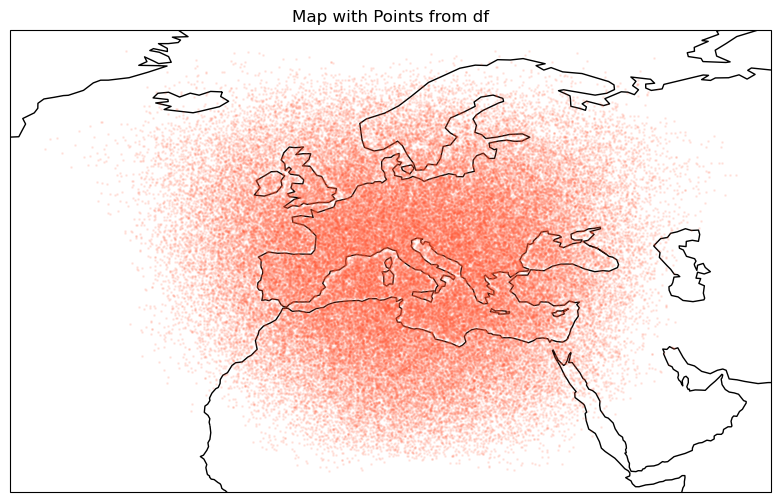

In [93]:
# Create a figure and axis with the PlateCarree projection
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use Plate Carree projection for global map

# Plot the points from df
ax.plot(
    df['lon'], df['lat'],
    'o', color='#FF5733', markersize=1, alpha=0.1,
    transform=ccrs.PlateCarree()    # Data coordinate system
)

# Add coastlines and gridlines for context
ax.coastlines()
# ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Set a title
plt.title("Map with Points from df")

# Show the plot
plt.show()


### Graph implementation

In [34]:
# Define a threshold for spatial and temporal proximity
spatial_threshold_km = 1500  # For example, nodes within 10 km
temporal_threshold_hours = 24  # For example, nodes within 24 hours

In [35]:
# Initialize lists for PyTorch Geometric
node_features = []
edges = []

In [36]:
# Step 1: Create a dictionary to map each (lat, lon, day, hour) combination to a node index
node_mapping = {}
index = 0
for _, row in df.iterrows():
    node_id = (row['lat'], row['lon'], row['day'])
    node_mapping[node_id] = index

    # Collect node features as a list of feature vectors
    feature_vector = torch.tensor([
        row['solar_zenith_angle'],
        row['solar_azimuth_angle'],
        # row['air_temp_masked'][0],
        row['surf_air_temp_masked'],
        row['surf_temp_masked'],
        row['surf_spec_hum_masked'],
        row['h2o_vap_tot_masked'],
        row['cloud_liquid_water_masked'],
        row['atmosphere_mass_content_of_cloud_ice_masked']
    ], dtype=torch.float)
    
    node_features.append(feature_vector)
    index += 1

# Convert node features to a tensor
x = torch.stack(node_features)


In [37]:
len(node_mapping.keys())

10

In [85]:

# Function to check proximity and return edges if the proximity thresholds are met
def check_proximity(pair):
    i, j = pair
    print(f"Checking pair {i} and {j}")
    node1, node2 = node_ids[i], node_ids[j]
    
    # Calculate spatial and temporal distances
    spatial_dist = geodesic((node1[0], node1[1]), (node2[0], node2[1])).km
    temporal_dist = abs((node1[2] - node2[2]).total_seconds()) / 3600
    
    print(f"Spatial distance: {spatial_dist} km, Temporal distance: {temporal_dist} hours")
    
    # Return edge if within proximity thresholds
    if temporal_dist < temporal_threshold_hours:
        return [node_mapping[node1], node_mapping[node2]]
    return None  # Return None if no edge is created

# Prepare pairs of indices to process
node_ids = list(node_mapping.keys())
node_pairs = [(i, j) for i in range(len(node_ids)) for j in range(i + 1, len(node_ids))]

print(f"Number of node pairs to check: {len(node_pairs)}")

# Use ProcessPoolExecutor for parallel processing
edges = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(check_proximity, node_pairs)
    
    # Collect non-None results (valid edges)
    edges = [edge for edge in results if edge is not None]

# Convert edges to a PyTorch tensor
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


Number of node pairs to check: 45
Checking pair 0 and 1Checking pair 0 and 2Checking pair 0 and 4Checking pair 0 and 5Checking pair 0 and 3Checking pair 0 and 6Checking pair 0 and 7

Checking pair 0 and 8



Spatial distance: 3946.852585444892 km, Temporal distance: 0.0 hoursSpatial distance: 1423.3009874898923 km, Temporal distance: 0.0 hoursSpatial distance: 3067.4979398083406 km, Temporal distance: 0.0 hours
Spatial distance: 2642.236594136179 km, Temporal distance: 0.0 hours

Spatial distance: 1262.614652887192 km, Temporal distance: 0.0 hours

Spatial distance: 1884.6836108167765 km, Temporal distance: 0.0 hours
Spatial distance: 1232.1149768577018 km, Temporal distance: 0.0 hoursSpatial distance: 915.7008185475771 km, Temporal distance: 0.0 hours
Checking pair 0 and 9Checking pair 1 and 2Checking pair 1 and 3



Checking pair 1 and 4

Checking pair 1 and 5Checking pair 1 and 7Checking pair 1 and 8Checking pair 1 and 6Spatial distance: 2553.9549387714337 km, Temporal distance: 0.0

In [86]:
# Step 3: Create a PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[10, 8], edge_index=[2, 45])


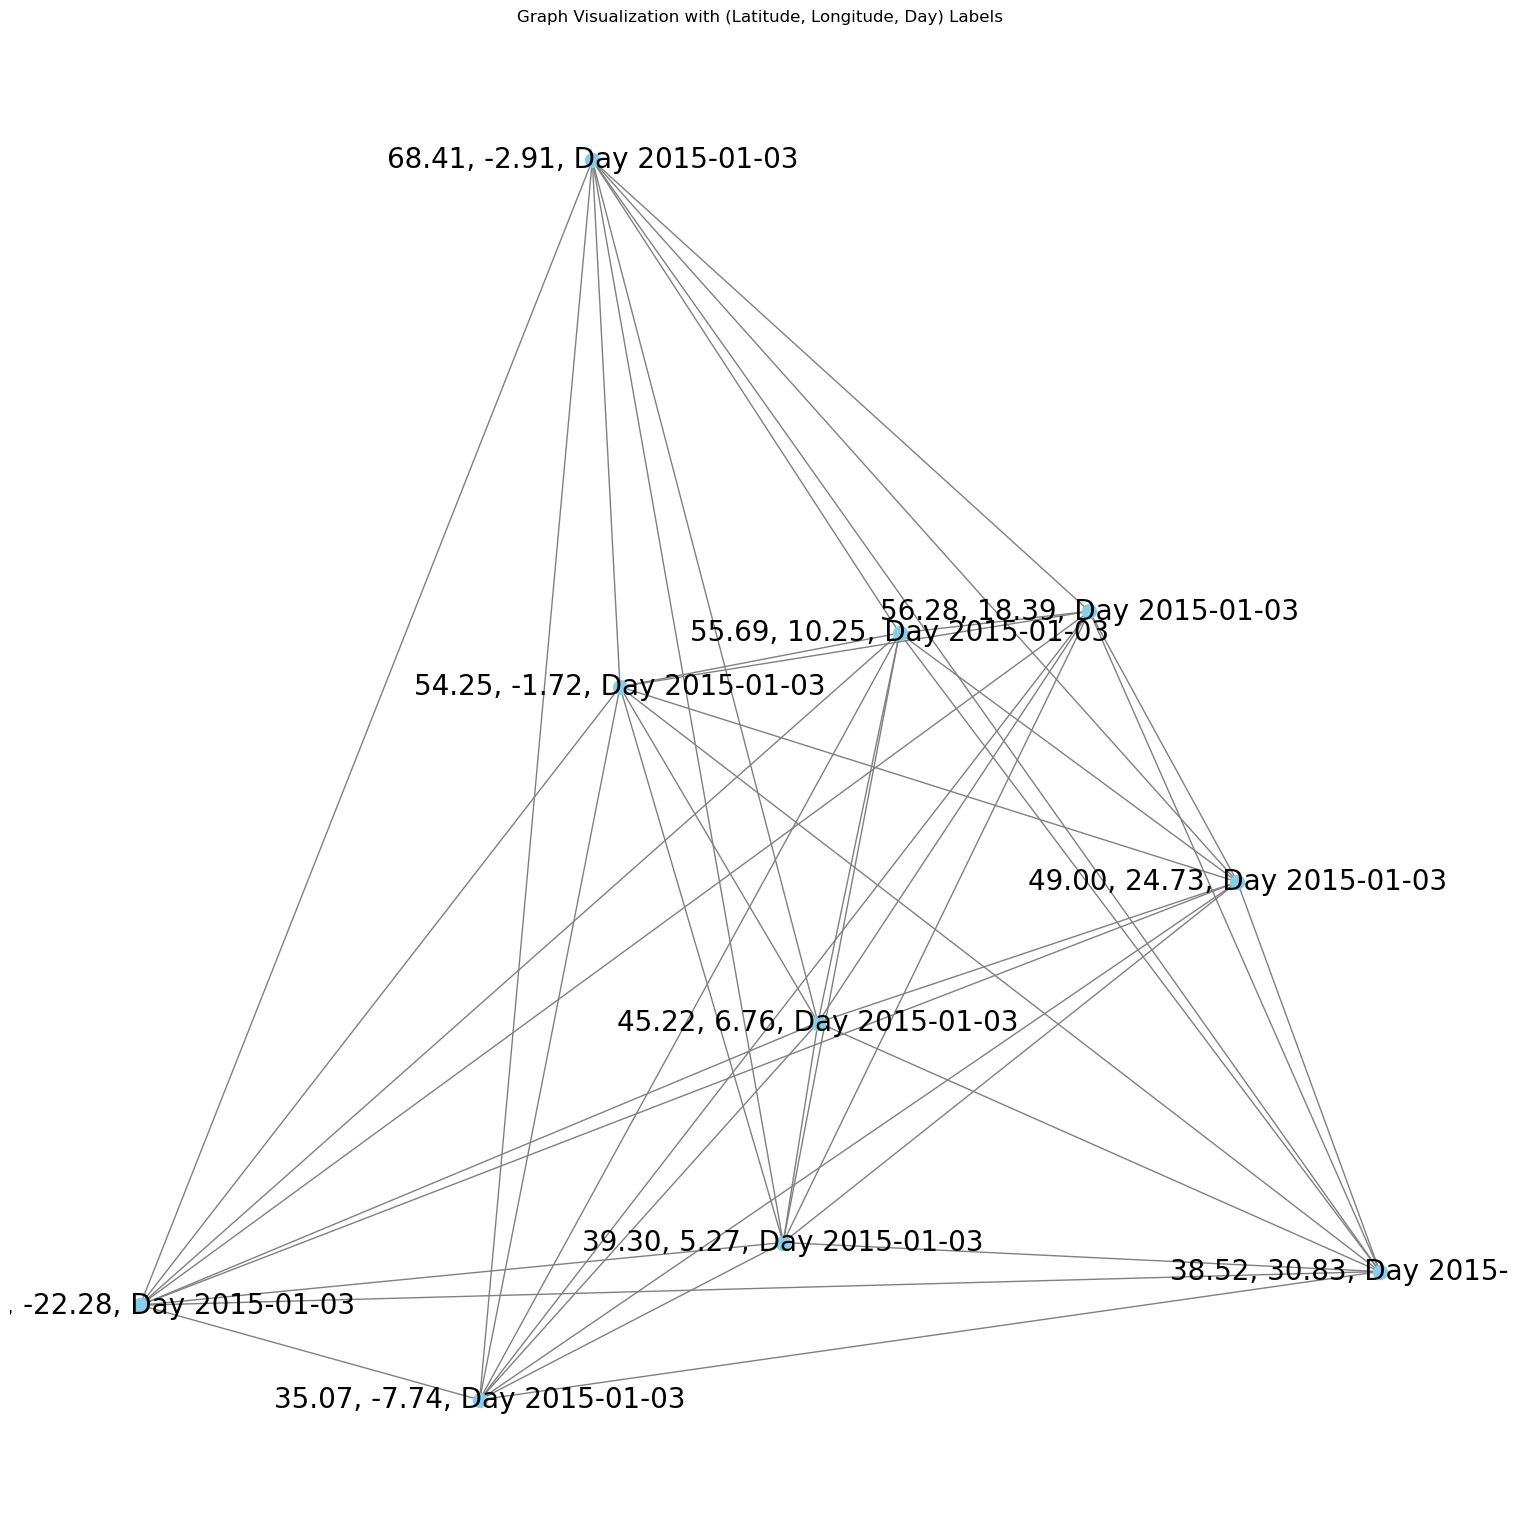

In [88]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

# Assume that `data` is the PyTorch Geometric data object created in your previous code.
# Also assume `node_mapping` dictionary and `node_ids` list are available from the previous steps

# Convert the PyTorch Geometric data object to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Create a dictionary with (lat, lon) positions for each node
positions = {node_mapping[node_id]: (node_id[1], node_id[0]) for node_id in node_ids}  # Note: (lon, lat) format for x, y


# Create a label dictionary with (lat, lon, day) as labels for each node
labels = {node_mapping[node_id]: f"{node_id[0]:.2f}, {node_id[1]:.2f}, Day {str(node_id[2]).split(' ')[0]}" for node_id in node_ids}

# Plot the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G)  # Use spring layout for a nice spread of nodes
nx.draw(G, pos=positions, with_labels=True, labels=labels, node_size=100, font_size=20, node_color="skyblue", edge_color="gray")
plt.title("Graph Visualization with (Latitude, Longitude, Day) Labels")
plt.show()
